# <font color='blue'>**EM-алгоритм**</font> 

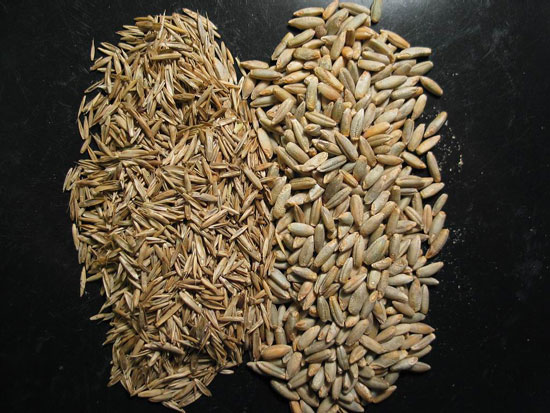

Настало время отделить зёрна от плевел.

# <font color='green'>0. Импорт необходимых модулей</font>  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
import itertools

Зафиксируем сид для генерации

In [ ]:
state = 42
np.random.seed(state)

# <font color='green'>1. Создание гауссовой смеси</font>  

## <font color='green'>1.1 Генерация сэмплов </font>  

Возьмём 1000 точек в 1ой гауссиане, 2000 во 2ой и 3000 точек в 3ьей

In [ ]:
n_samples = [1000, 2000, 3000]
n_comp = len(n_samples)
n = sum(n_samples)

Центры и матрицы ковариации гауссиан

In [ ]:
mu0 = np.array([-10.0, -10.0])
Cov0 = np.array([[1.0, 0.0], [0.0, 1.0]])

mu1 = np.array([0.0, 0.0])
Cov1 = np.array([[5.0, 0.0], [0.0, 0.5]])

mu2 = np.array([10.0, 0.75])
Cov2 = np.array([[1.0, 0.0], [0.0, 3.0]])

mu = np.array([mu0, mu1, mu2])
Cov = np.array([Cov0, Cov1, Cov2])

Генерируем гауссианы и сразу объединяем их в один numpy-массив

In [ ]:
X = np.r_[ 
    np.dot(np.random.randn(n_samples[0], 2), Cov0) + mu0,
    np.dot(np.random.randn(n_samples[1], 2), Cov1) + mu1,
    np.dot(np.random.randn(n_samples[2], 2), Cov2) + mu2,
]

Метки класса для гауссиан

In [ ]:
Y = np.zeros(sum(n_samples))
Y[n_samples[0]:n_samples[0]+n_samples[1]] = 1
Y[n_samples[0]+n_samples[1]:] = 2
assert sum(Y == 1) == n_samples[1]
assert sum(Y == 2) == n_samples[2]

## <font color='green'>1.2 Посмотрим на эти гауссианы </font> 

Цвета для гауссиан

In [ ]:
colors = ["green", "navy", "darkorange"]

Визуализация

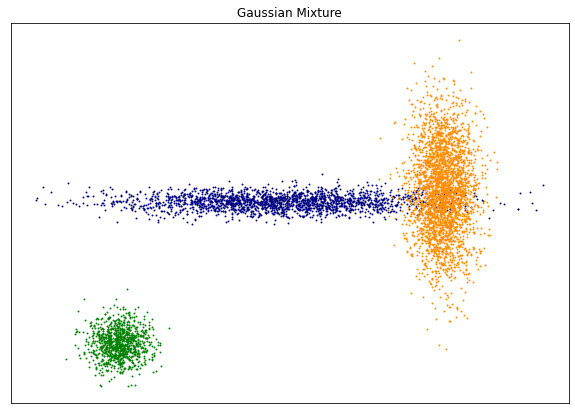

In [ ]:
plt.figure(figsize=(10,7))
for i, color in enumerate(colors):
  plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)
plt.xticks(())
plt.yticks(())
plt.title(
    f"Gaussian Mixture"
)
plt.show()

# <font color='green'> Soft VS Hard </font>  

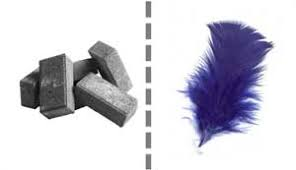

Разделение гауссовых смесей - частный случай задачи кластеризации. Есть разница между Soft и Hard решениями этой задачи:

*   **Hard Clustering** - мы требуем жёсткого разделение между кластерами, каждая точка принадлежит ровно 1 кластеру.

Мы рассмотрим пример такого алгоритма -  **<font color='red'>K-Means</font>**.

*   **Soft Clustering**. Одна и та же точка может лежать в разных кластерах с разной вероятностью. 

**<font color='red'>EM-алгоритм</font>** - пример мягкой кластеризации. 

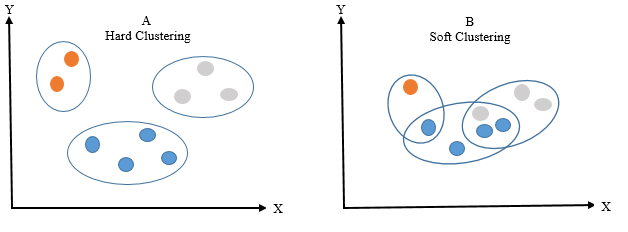

#  **<font color='blue'>K-Means</font>** 

**K-Means** - один из простейших алгоритмов кластеризации. 

Мы итеративно выполняем 2 шага:

*  (**M-шаг**) выбираем центры $K$ кластеров $\mu_1, \dots, \mu_k$
*  (**E-шаг**) распределяем точки по $x_1,\dots, x_n$ по кластерам,

стремясь минимизировать <font color='blue'>инерцию</font> 
$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

На каждом шаге можно найти явный минимум инерции. Получается следующий алгоритм:

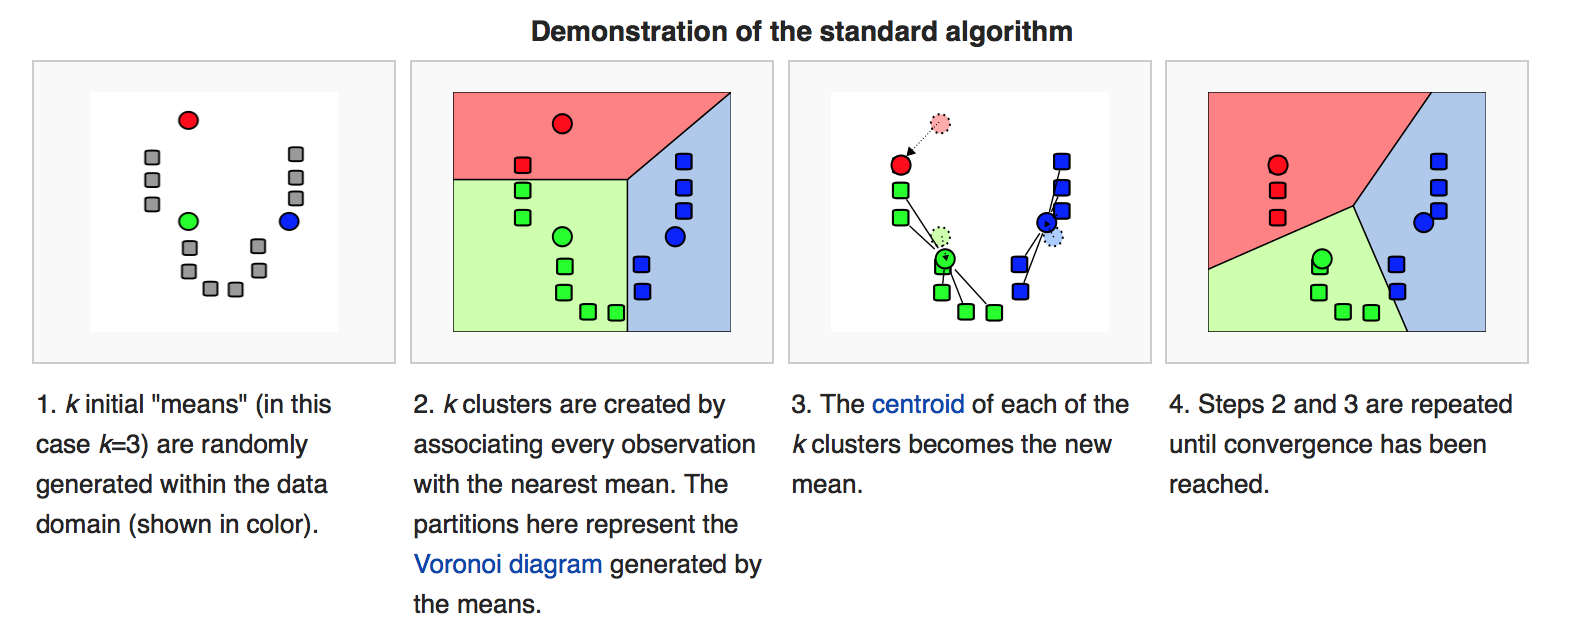

Подробнее см. Главу 9.1 

*   *Bishop C. M. "Pattern Recognition and Machine Learning"*

В Главе 9.3.2 показано, что K-Means эквивалентен EM-алгоритму, если все матрицы ковариации - равные маленькие диагональные матрицы $\Sigma_i = \epsilon E$.


# <font color='green'>2. E-шаг </font>  

Введём $r_{nk}$ - индикаторы принадлежности точек кластерам. 

Если точка $x_n$ принадлежит $k$-тому кластеру: $$ r_{nk} = 1, \qquad r_{nj} = 0, \quad j\not = k.$$


На E-шаге обновляем  $$r(  z_k)  = 1, \qquad k = \arg \min_k \left\|x_n - \mu_k \right\|^2$$

In [ ]:
def e_step(X, K, mu):
    N = len(X)
    r = np.zeros((N, K))
    for n in range(N):
      dist = [np.linalg.norm(X[n] - mu[k, :]) for k in range(K)]
      k = np.argmin(dist)
      r[n, k] = 1
    return r

Проверка

In [ ]:
r = e_step(X, n_comp, mu)
assert r.shape == (n, n_comp)
assert np.allclose(r.sum(axis=1), np.ones(n))

# <font color='green'>3. M-шаг </font>  

Обновляем центры кластеров.

Новые центры --- взвешенные среднее данных точек: $$ \mu_k =  \frac{\sum_{n=1}^N  r_{nk} x_n}{\sum_{n=1}^N  r_{nk} }. $$


In [ ]:
def m_step(X, K, r):
  return r.T.dot(X) / r.sum(axis=0)[:,np.newaxis] 

Проверка

In [ ]:
mu = m_step(X, n_comp, r)
assert mu.shape == (n_comp, 2)

# <font color='green'>4. Применение алгоритма </font>  

Нужно учесть - *номера кластеров в ответе могут быть переставлены*. 

Поэтому скор - нужно брать максимум угаданных точек для всех перестановок номеров кластеров.

In [ ]:
list(itertools.permutations([1, 2, 3]))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

In [ ]:
def score(Y_pred, Y_true):
  max_score = []
  for perm in list(itertools.permutations(np.arange(n_comp))):  
    val_perm = np.vectorize(lambda x: perm[int(x)])
    Y_perm = val_perm(Y_true)
    max_score.append(round(accuracy_score(Y_perm, Y_pred), n_comp))
  return max(max_score)

В качестве **начальных центров** $\mu_i$ возьмём *центры для случайного разбиение данных точек на 3 равные части*.

In [ ]:
mu =  np.array([np.mean(X[np.random.choice(len(X), len(X)//n_comp)], axis = 0) for k in range(n_comp)])

Также нарисуем диаграмму Вороного для центров кластеров

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d

### Основной цикл

Итерация №1
Доля правильно распознанных точек 0.748


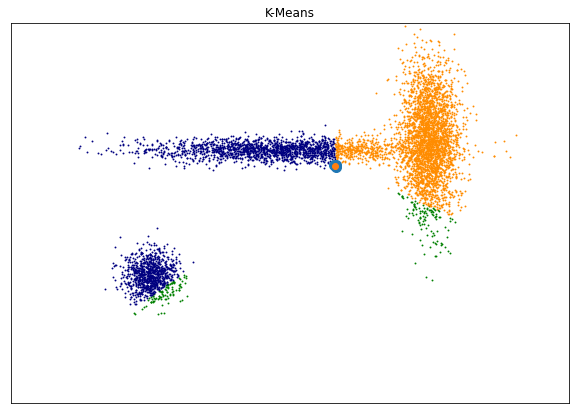

Итерация №2
Доля правильно распознанных точек 0.712


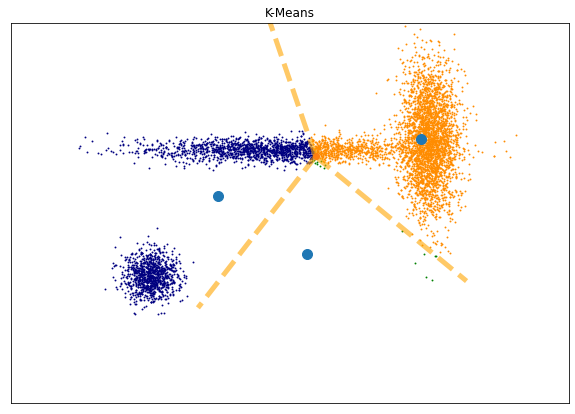

Итерация №3
Доля правильно распознанных точек 0.765


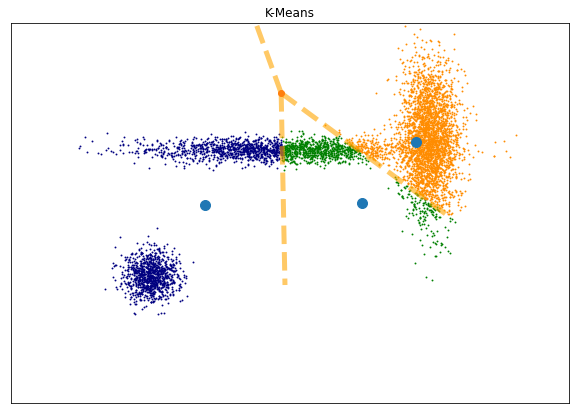

Итерация №4
Доля правильно распознанных точек 0.882


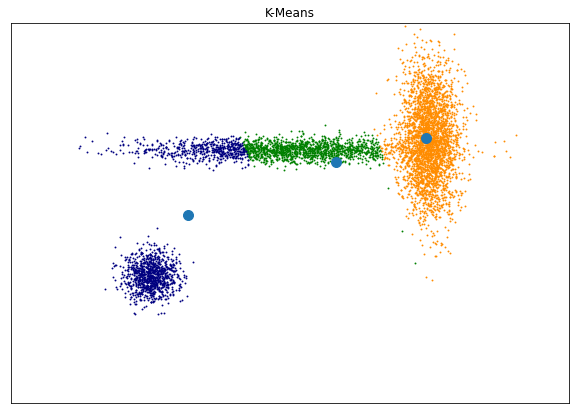

Итерация №5
Доля правильно распознанных точек 0.918


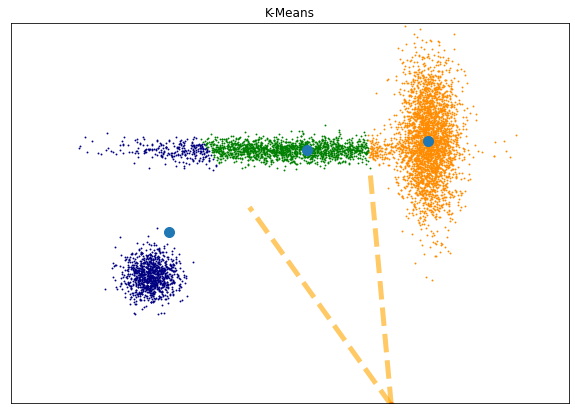

Итерация №6
Доля правильно распознанных точек 0.929


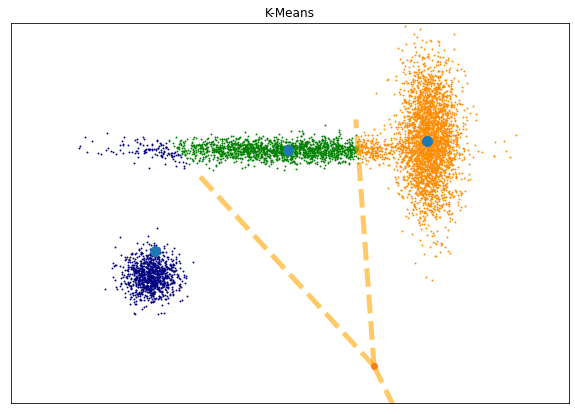

Итерация №7
Доля правильно распознанных точек 0.932


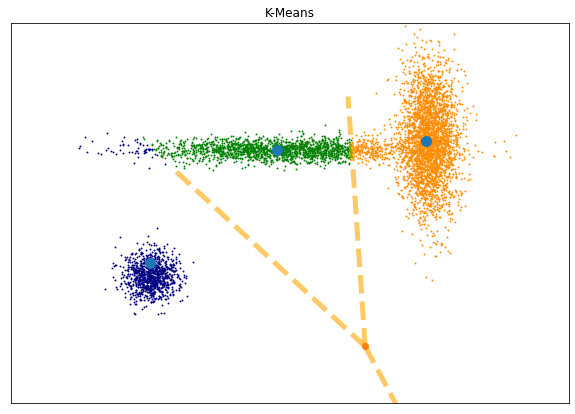

Итерация №8
Доля правильно распознанных точек 0.931


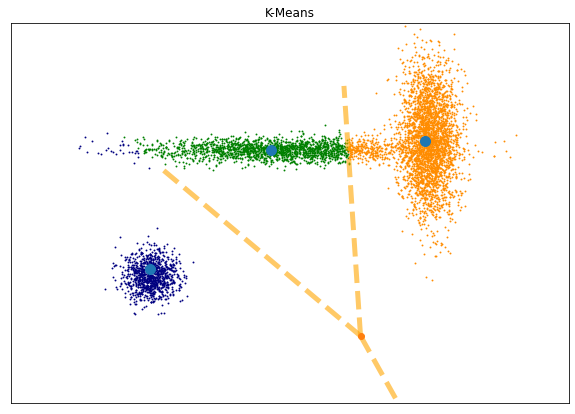

Итерация №9
Доля правильно распознанных точек 0.93


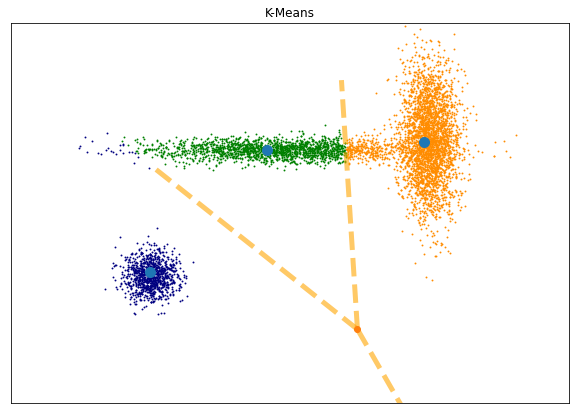

Итерация №10
Доля правильно распознанных точек 0.929


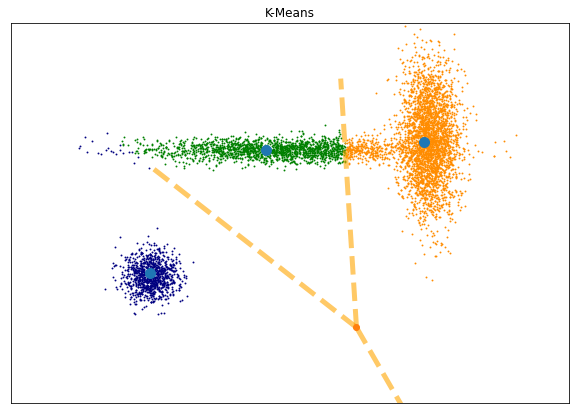

In [ ]:
# выберем количество итераций EM-алгоритма
steps = 10
# запустим цикл EM-алгоритма
for i in range(steps):
    # E-шаг
    r = e_step(X, n_comp, mu)
     
    # Предсказания кластеров
    Y_ = r.argmax(axis=1)
  
    print(f'Итерация №{i+1}')
    print(f'Доля правильно распознанных точек {score(Y_, Y)}')    

    # Визуализация
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    # Рисуем точки из разных кластеров 
    for i, color in enumerate(colors):
      ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1],  0.8, color=color)

    # Диаграмма Вороного для центров кластеров
    vor = Voronoi(mu)
    voronoi_plot_2d(vor, show_vertices=True, line_colors='orange',
                line_width=5, line_alpha=0.6, point_size=20, ax=ax)

    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 10)

    plt.xticks(())
    plt.yticks(())
    plt.title(
        f"K-Means"
    )
    plt.show()

    # M-шаг
    mu = m_step(X,  n_comp, r) 

# <font color='green'>5. True way </font>  

Зачем мучиться, если всё уже реализовано за нас?

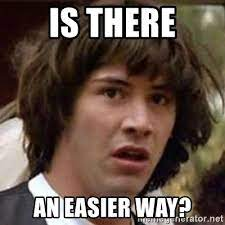

# <font color='green'>5.1 K-Means </font>  

In [ ]:
from sklearn.cluster import KMeans

Решение - в одну строчку

In [ ]:
kmeans = KMeans(n_clusters=n_comp, random_state=state).fit(X)

Та же визуализация

Доля правильно распознанных точек 0.929


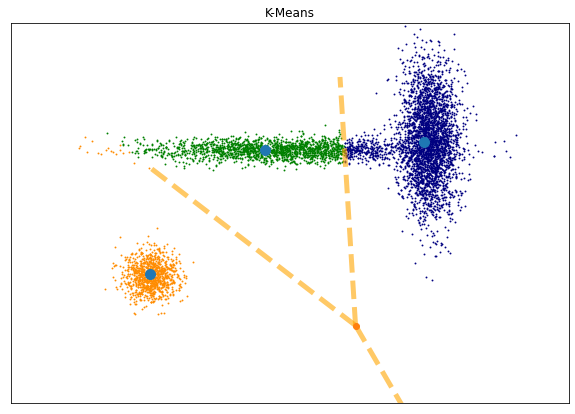

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

Y_ = kmeans.labels_
print(f'Доля правильно распознанных точек {score(Y_, Y)}')

for i, color in enumerate(colors):
  ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1],  0.8, color=color)

# Диаграмма Вороного для центров кластеров
vor = Voronoi(kmeans.cluster_centers_)
voronoi_plot_2d(vor, show_vertices=True, line_colors='orange',
            line_width=5, line_alpha=0.6, point_size=20, ax=ax)

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 10)

plt.xticks(())
plt.yticks(())
plt.title(
    f"K-Means"
)
plt.show()

# <font color='green'>5.2 EM </font>  

In [ ]:
from sklearn.mixture import GaussianMixture

И снова - одна строчка

In [ ]:
labels = GaussianMixture(n_components=n_comp, random_state=state).fit_predict(X)

Та же визуализация

Доля правильно распознанных точек 0.98


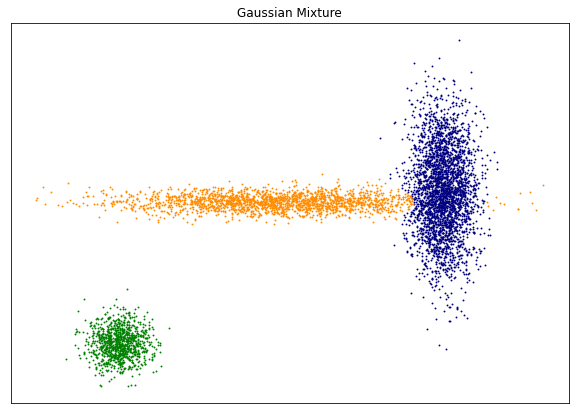

In [ ]:
Y_ = labels

print(f'Доля правильно распознанных точек {score(Y_, Y)}')    

plt.figure(figsize=(10,7))
for i, color in enumerate(colors):
  plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1],  0.8, color=color)
plt.xticks(())
plt.yticks(())
plt.title(
    f"Gaussian Mixture"
)
plt.show()